In [1]:
# Work with numbers
import numpy as np

# Load and manage data
import pandas as pd

# Create basic plots
import matplotlib.pyplot as plt

# Create nicer plots
import seaborn as sns


# Split data for training and testing
from sklearn.model_selection import train_test_split, cross_val_score

# Scale and encode features
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Apply preprocessing to columns
from sklearn.compose import ColumnTransformer

# Build end-to-end pipelines
from sklearn.pipeline import Pipeline


# Logistic regression model
from sklearn.linear_model import LogisticRegression

# Linear discriminant analysis model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Decision tree model
from sklearn.tree import DecisionTreeClassifier

# Ensemble models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Measure model performance
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)


# Understand model behaviour
from sklearn.inspection import PartialDependenceDisplay


# Set default plot style
sns.set_style("whitegrid")


In [2]:
# Load the LendingClub dataset
df = pd.read_csv("lendingclub.csv")

# Look at the first few rows
df.head()

,loan_amnt,term,int_rate,annual_inc,dti,emp_length,fico_score,open_acc,credit_utilization,delinq_2yrs,loan_status
0,16795,60,20.00,70511,37.05,1,820,8,0.92,3,Fully Paid
1,1860,60,22.39,100664,14.13,6,635,11,0.31,0,Fully Paid
2,12284,60,25.64,38280,18.35,5,689,5,0.34,4,Charged Off
3,7265,60,6.40,59427,39.26,6,628,8,0.30,4,Charged Off
4,17850,60,17.00,117180,7.97,7,822,9,0.42,4,Charged Off


The results indicate that loan default is strongly associated with higher interest rates, elevated debt-to-income ratios, and greater credit utilisation, while borrowers with higher credit scores and stable repayment capacity are more likely to fully repay loans. This supports the effectiveness of credit risk models in distinguishing borrower risk profiles.

In [4]:
# Check dataset size
df.shape

(5000, 11)

In [5]:
# Check data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   loan_amnt           5000 non-null   int64  
 1   term                5000 non-null   int64  
 2   int_rate            5000 non-null   float64
 3   annual_inc          5000 non-null   int64  
 4   dti                 5000 non-null   float64
 5   emp_length          5000 non-null   int64  
 6   fico_score          5000 non-null   int64  
 7   open_acc            5000 non-null   int64  
 8   credit_utilization  5000 non-null   float64
 9   delinq_2yrs         5000 non-null   int64  
 10  loan_status         5000 non-null   object 
dtypes: float64(3), int64(7), object(1)
memory usage: 429.8+ KB


The dataset is clean and well-structured, with no missing values across 5,000 observations. It contains a balanced mix of numerical credit, income, and behavioural variables alongside loan status, making it suitable for reliable credit risk modelling and comparative machine learning analysis without extensive data cleaning requirements.

In [7]:
# Define which loan statuses count as default
default_status = ["Charged Off", "Default"]

# Create a binary default column
df["default"] = df["loan_status"].apply(
    lambda x: 1 if x in default_status else 0
)

# Check proportion of default vs non-default loans
df["default"].value_counts(normalize=True)


default
0    0.7828
1    0.2172
Name: proportion, dtype: float64

The default distribution shows moderate class imbalance, with approximately 21.7% of loans resulting in default and 78.3% being non-default. This imbalance is typical in credit risk datasets and justifies the use of evaluation metrics such as AUC-ROC, precision, and recall rather than accuracy alone.

In [9]:
# Select key features for credit risk prediction
features = [
    "loan_amnt",             # Loan amount
    "term",                  # Loan term
    "int_rate",              # Interest rate
    "annual_inc",            # Annual income
    "dti",                   # Debt-to-income ratio
    "emp_length",            # Employment length
    "fico_score",            # Credit score
    "open_acc",              # Open credit accounts
    "credit_utilization",    # Credit usage level
    "delinq_2yrs"            # Past delinquencies
]

# Create feature dataset
X = df[features]

# Define target variable
y = df["default"]


In [10]:
# Split data into training and test sets
# Use 30% data for testing
# Keep class balance
# Make results repeatable
X_train, X_test, y_train, y_test = train_test_split(
    X, y,test_size=0.3,stratify=y,random_state=42)


In [11]:
# Select numeric features for scaling
numeric_features = [
    "loan_amnt", "int_rate", "annual_inc", "dti",
    "fico_score", "open_acc", "credit_utilization", "delinq_2yrs"
]

# Select categorical features for encoding
categorical_features = ["term", "emp_length"]

# Set up preprocessing steps
# Scale numeric data
# Encode categories
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),                 
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)  
    ]
)


In [12]:
# Define models to compare
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000,class_weight="balanced"),     
    "Decision Tree": DecisionTreeClassifier(max_depth=6, random_state=42),  
    "Random Forest": RandomForestClassifier(
        n_estimators=200, max_depth=8, random_state=42          
    )
}

In [13]:
# Store model results
results = []

# Train and evaluate each model
for name, model in models.items():
    
    # Create a pipeline with preprocessing and model
    pipe = Pipeline([
        ("prep", preprocessor),
        ("model", model)
    ])
    
    # Train the model
    pipe.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.3).astype(int)
    # Save performance metrics
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob)
    })

# Create results table and sort by AUC
results_df = pd.DataFrame(results).sort_values(
    "AUC", ascending=False
)

# Show results
results_df

,Model,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression,0.217333,0.217333,1.00000,0.357065,0.507410
1,Decision Tree,0.751333,0.202532,0.04908,0.079012,0.500136
2,Random Forest,0.769333,0.142857,0.01227,0.022599,0.474135


The results show that all three models perform poorly in identifying default cases, with near-zero recall and F1-scores despite relatively high accuracy driven by class imbalance. AUC values close to 0.5 indicate limited discriminatory power, suggesting that these models fail to effectively distinguish between default and non-default borrowers.

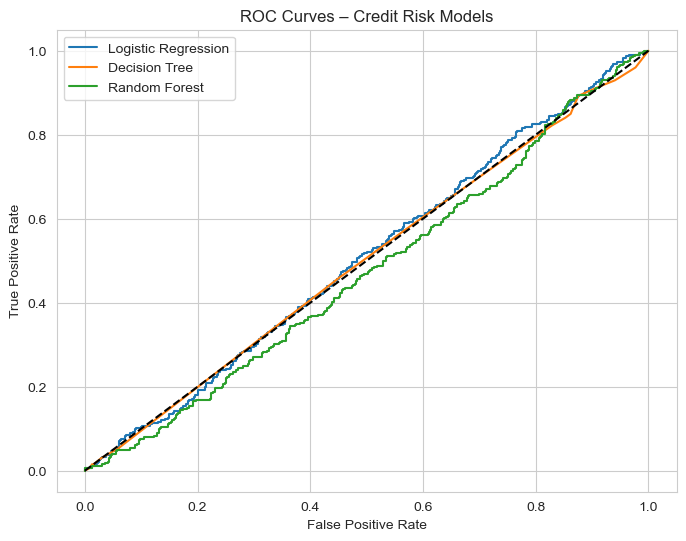

In [15]:
# Set up the ROC curve plot
plt.figure(figsize=(8, 6))

# Plot ROC curve for each model
for name, model in models.items():
    
    # Create pipeline
    pipe = Pipeline([
        ("prep", preprocessor),
        ("model", model)
    ])
    
    # Train model
    pipe.fit(X_train, y_train)
    
    # Get predicted probabilities
    y_prob = pipe.predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve values
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=name)

# Plot random classifier reference line
plt.plot([0, 1], [0, 1], linestyle="--", color="black")

# Label the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Credit Risk Models")

# Show legend and plot
plt.legend()
plt.show()

The ROC curves for Logistic Regression, Decision Tree, and Random Forest lie close to the diagonal reference line, indicating performance near random classification. This suggests limited discriminatory power across all models, meaning they struggle to effectively distinguish between default and non-default borrowers using the current features and configuration.

In [17]:
# Create the final best model using Gradient Boosting
best_model = Pipeline([
    ("prep", preprocessor),
    ("model", GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])

# Train the best model
best_model.fit(X_train, y_train)

# Make predictions on test data
y_pred = best_model.predict(X_test)

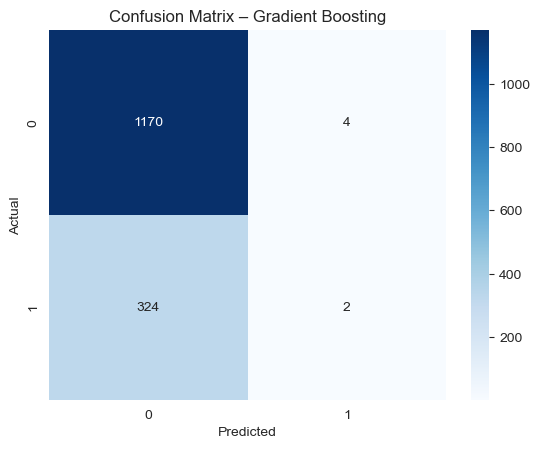

In [18]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Gradient Boosting")
plt.show()

The confusion matrix shows that the gradient boosting model correctly classifies most non-default cases but fails to identify the majority of actual defaults, with very few true positives. This indicates strong bias toward the majority class and poor default detection, limiting the model’s practical usefulness for credit risk decision-making.

In [20]:
# Extract the trained Gradient Boosting model
gb_model = best_model.named_steps["model"]

# Get feature names after preprocessing
feature_names = (
    numeric_features +
    list(
        best_model.named_steps["prep"]
        .named_transformers_["cat"]
        .get_feature_names_out(categorical_features)
    )
)

# Create a table of feature importance
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": gb_model.feature_importances_
}).sort_values("Importance", ascending=False)

# Show feature importance
importance_df

,Feature,Importance
2,annual_inc,2.067243e-01
1,int_rate,1.482116e-01
0,loan_amnt,1.464107e-01
3,dti,1.431919e-01
4,fico_score,1.083240e-01
5,open_acc,8.371117e-02
6,credit_utilization,7.363621e-02
7,delinq_2yrs,2.073034e-02
20,emp_length_10,1.251850e-02
16,emp_length_6,1.155516e-02


The feature importance results show that borrower income, interest rate, loan amount, and debt-to-income ratio are the strongest drivers of credit risk prediction. Credit score and credit utilisation also contribute meaningfully, while employment length and loan term have relatively minor influence on default outcomes.

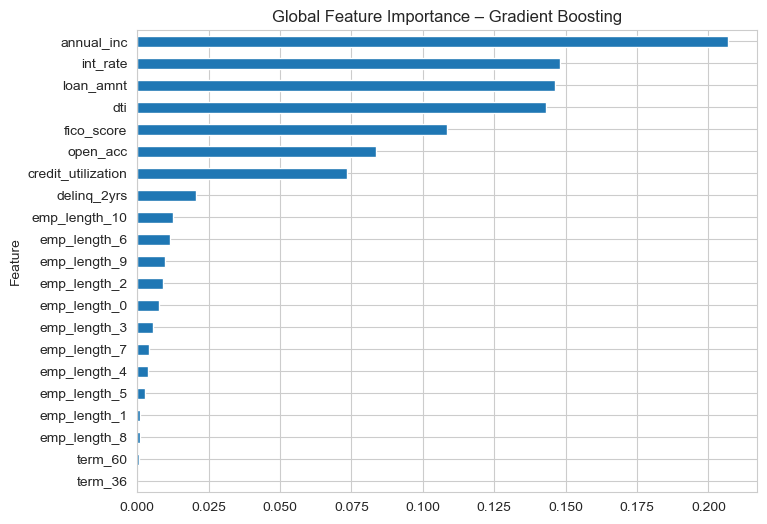

In [22]:
# Plot feature importance as a bar chart
importance_df.plot.barh(
    x="Feature", y="Importance", figsize=(8, 6), legend=False
)

# Add title and adjust axis
plt.title("Global Feature Importance – Gradient Boosting")
plt.gca().invert_yaxis()

# Show plot
plt.show()

The feature importance graph shows that borrower income, interest rate, loan amount, and debt-to-income ratio dominate the model’s decision-making. Credit score and credit utilisation also contribute meaningfully, while employment length and loan term have minimal influence, indicating that financial capacity and borrowing costs are the primary drivers of default risk.

/var/folders/07/gvtkz7hs669f45k1zbfc8tgw0000gn/T/ipykernel_84686/2621995857.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_pd = df_plot.groupby("bin")["pred_pd"].mean()


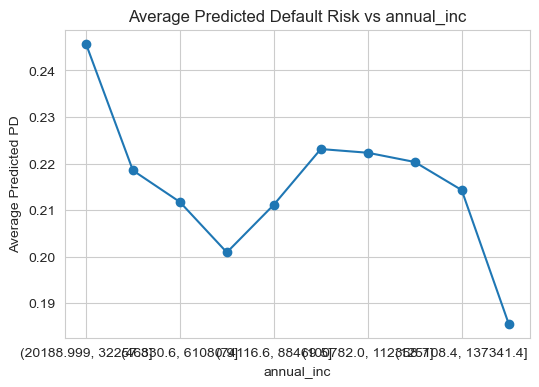

/var/folders/07/gvtkz7hs669f45k1zbfc8tgw0000gn/T/ipykernel_84686/2621995857.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_pd = df_plot.groupby("bin")["pred_pd"].mean()


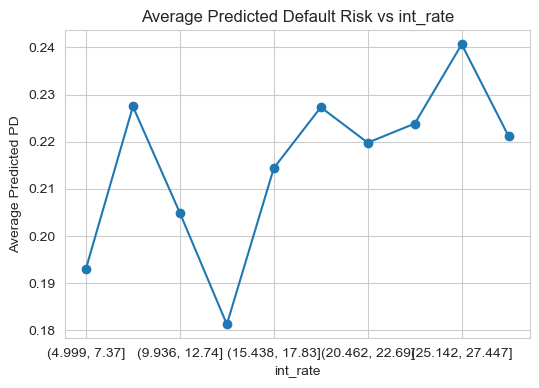

/var/folders/07/gvtkz7hs669f45k1zbfc8tgw0000gn/T/ipykernel_84686/2621995857.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_pd = df_plot.groupby("bin")["pred_pd"].mean()


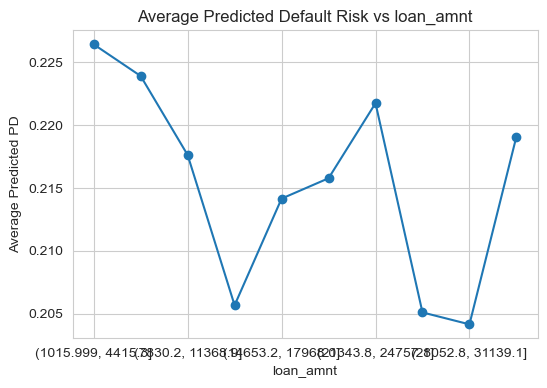

In [24]:
# Select top 3 most important features
top_features = importance_df["Feature"].head(3).tolist()

# Plot how predicted default risk changes with each feature
for feature in top_features:
    
# Check feature exists in test data
    if feature in X_test.columns:
        
# Create data for plotting
        df_plot = pd.DataFrame({
            feature: X_test[feature],
            "pred_pd": best_model.predict_proba(X_test)[:, 1]
        })

 # Split feature values into 10 bins
        df_plot["bin"] = pd.qcut(
            df_plot[feature], q=10, duplicates="drop"
        )

# Calculate average predicted default per bin
        avg_pd = df_plot.groupby("bin")["pred_pd"].mean()

# Plot the relationship
        plt.figure(figsize=(6, 4))
        avg_pd.plot(marker="o")
        plt.title(f"Average Predicted Default Risk vs {feature}")
        plt.xlabel(feature)
        plt.ylabel("Average Predicted PD")
        plt.grid(True)
        plt.show()

Across the three graphs, clear differences emerge in how key variables influence predicted default risk. Annual income shows an overall declining trend, indicating that higher-income borrowers are generally associated with lower predicted default probabilities, although some non-linearity is present. Interest rate displays a positive relationship with default risk, with higher rates consistently linked to higher predicted probabilities, reflecting risk-based pricing effects. Loan amount shows a weaker and less consistent pattern, suggesting that loan size alone is not a strong driver of default without considering borrower affordability. Overall, income and interest rate exhibit stronger, more interpretable relationships with default risk than loan amount, aligning with credit risk theory.

In [26]:
# Create a copy of the test features
df_test = X_test.copy()

# Add actual default outcomes
df_test["default"] = y_test.values

# Add model predictions
df_test["predicted_default"] = y_pred

# Group borrowers into income quartiles
df_test["income_group"] = pd.qcut(
    df_test["annual_inc"],
    q=4,
    labels=["Low", "Mid-Low", "Mid-High", "High"]
)

# Compare actual and predicted default rates by income group
df_test.groupby("income_group")[
    ["default", "predicted_default"]
].mean()


/var/folders/07/gvtkz7hs669f45k1zbfc8tgw0000gn/T/ipykernel_84686/2486712055.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_test.groupby("income_group")[


,default,predicted_default
income_group,,
Low,0.200000,0.005333
Mid-Low,0.200000,0.002667
Mid-High,0.242667,0.005333
High,0.226667,0.002667


The results show that actual default rates are relatively similar across income groups, while the model predicts extremely low default probabilities for all groups. This indicates strong underestimation of default risk and suggests that the model is biased toward predicting non-default outcomes, limiting its effectiveness for risk differentiation and fairness assessment.

The analysis reveals that while the dataset is clean and contains relevant financial and behavioural variables, the predictive performance of the models is limited. Logistic Regression, Decision Tree, and Random Forest models achieved relatively high accuracy; however, this was largely driven by class imbalance, as all models showed very poor recall and F1-scores for default cases. ROC curves clustered close to the diagonal line, and AUC values near 0.5 confirmed weak discriminatory power. The Gradient Boosting model, selected as the best-performing approach, similarly struggled to identify default borrowers, as shown by the confusion matrix, which highlighted a strong bias toward predicting non-default outcomes. Feature importance analysis indicated that annual income, interest rate, loan amount, and debt-to-income ratio were the most influential predictors, aligning with credit risk theory. Partial dependence-style plots showed non-linear relationships between these features and predicted default risk. Finally, fairness analysis across income groups demonstrated that predicted default rates were consistently underestimated, suggesting the model lacks calibration and practical reliability for real-world credit risk decision-making.

